# Diabetes Prediction - Model Training & Evaluation

This notebook trains and evaluates multiple classification algorithms.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
import utils

# Sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
import joblib

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(config.COLOR_PALETTE)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed data
X_train = np.load(f'{config.DATA_DIR}/X_train_scaled.npy')
X_test = np.load(f'{config.DATA_DIR}/X_test_scaled.npy')
y_train = np.load(f'{config.DATA_DIR}/y_train.npy')
y_test = np.load(f'{config.DATA_DIR}/y_test.npy')

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {int(cls)}: {count} samples ({count/len(y_train)*100:.1f}%)")

Training set: (614, 8)
Test set: (154, 8)

Class distribution in training set:
  Class 0: 400 samples (65.1%)
  Class 1: 214 samples (34.9%)


## 2. Initialize Models

In [3]:
# Define all models
models = {
    'Logistic Regression': LogisticRegression(**config.MODEL_PARAMS['logistic_regression']),
    'Decision Tree': DecisionTreeClassifier(**config.MODEL_PARAMS['decision_tree']),
    'Random Forest': RandomForestClassifier(**config.MODEL_PARAMS['random_forest']),
    'KNN': KNeighborsClassifier(**config.MODEL_PARAMS['knn']),
    'Naive Bayes': GaussianNB(**config.MODEL_PARAMS['naive_bayes'])
}

print(f"Initialized {len(models)} classification models:")
for name in models.keys():
    print(f"  - {name}")

Initialized 5 classification models:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - KNN
  - Naive Bayes


## 3. Train and Evaluate All Models

In [4]:
# Store results
results = {}
trained_models = {}

print("Training models...\n")
print("="*80)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train model
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    
    # Evaluate model
    metrics = utils.evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = metrics
    
    # Print results
    utils.print_classification_metrics(model_name, metrics)

print("="*80)
print("\nAll models trained successfully!")

Training models...


Training Logistic Regression...

Logistic Regression Performance Metrics
Train Accuracy:     0.7964
Test Accuracy:      0.7078
Precision:          0.6000
Recall:             0.5000
F1-Score:           0.5455
ROC-AUC:            0.8130
CV Mean (±std):     0.7818 (±0.0125)


Training Decision Tree...

Decision Tree Performance Metrics
Train Accuracy:     0.9625
Test Accuracy:      0.6753
Precision:          0.5455
Recall:             0.4444
F1-Score:           0.4898
ROC-AUC:            0.6821
CV Mean (±std):     0.6874 (±0.0263)


Training Random Forest...

Random Forest Performance Metrics
Train Accuracy:     0.9919
Test Accuracy:      0.7532
Precision:          0.6739
Recall:             0.5741
F1-Score:           0.6200
ROC-AUC:            0.8126
CV Mean (±std):     0.7655 (±0.0287)


Training KNN...

KNN Performance Metrics
Train Accuracy:     0.8306
Test Accuracy:      0.7532
Precision:          0.6600
Recall:             0.6111
F1-Score:           0.6346
ROC-A

## 4. Compare Model Performance

In [5]:
# Create results DataFrame
results_df = pd.DataFrame({
    'model': list(results.keys()),
    'train_accuracy': [metrics['train_accuracy'] for metrics in results.values()],
    'test_accuracy': [metrics['test_accuracy'] for metrics in results.values()],
    'precision': [metrics['precision'] for metrics in results.values()],
    'recall': [metrics['recall'] for metrics in results.values()],
    'f1_score': [metrics['f1_score'] for metrics in results.values()],
    'roc_auc': [metrics['roc_auc'] for metrics in results.values()],
    'cv_mean': [metrics['cv_mean'] for metrics in results.values()],
    'cv_std': [metrics['cv_std'] for metrics in results.values()]
})

# Calculate overfitting gap for analysis
results_df['overfitting_gap'] = results_df['train_accuracy'] - results_df['test_accuracy']

# Sort by F1-score (best metric for medical classification)
results_df = results_df.sort_values('f1_score', ascending=False).reset_index(drop=True)

print("\nModel Performance Summary:")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

# Overfitting warnings (informational only, no penalties applied)
print("\n⚠️  OVERFITTING ANALYSIS:")
has_overfitting = False
for idx, row in results_df.iterrows():
    if row['overfitting_gap'] > 0.15:
        print(f"  WARNING: {row['model']} shows significant overfitting (gap: {row['overfitting_gap']:.1%})")
        has_overfitting = True
if not has_overfitting:
    print("  ✓ No significant overfitting detected (all gaps < 15%)")

print("\n📊 MODEL SELECTION CRITERIA:")
print("  • Primary Metric: F1-Score (balances precision & recall for medical diagnosis)")
print("  • Why F1: Considers both false positives and false negatives")
print("  • Overfitting check: Informational warnings, no automatic penalties")
print("  • Cross-validation already provides generalization estimate")

best_model_row = results_df.iloc[0]
print(f"\n✓ Best Model: {best_model_row['model']}")
print(f"  - F1-Score (test): {best_model_row['f1_score']:.4f}")
print(f"  - Accuracy (test): {best_model_row['test_accuracy']:.4f}")
print(f"  - Precision: {best_model_row['precision']:.4f}")
print(f"  - Recall: {best_model_row['recall']:.4f}")
print(f"  - ROC-AUC: {best_model_row['roc_auc']:.4f}")
print(f"  - CV Score: {best_model_row['cv_mean']:.4f} (±{best_model_row['cv_std']:.4f})")
print(f"  - Overfitting Gap: {best_model_row['overfitting_gap']:.1%}")

# Save results
results_df.to_csv(f'{config.RESULTS_DIR}/model_performance.csv', index=False)
print(f"\nResults saved to: {config.RESULTS_DIR}/model_performance.csv")


Model Performance Summary:
              model  train_accuracy  test_accuracy  precision   recall  f1_score  roc_auc  cv_mean   cv_std
      Random Forest        0.991857       0.753247   0.673913 0.574074  0.620000 0.812593 0.765480 0.028738
                KNN        0.830619       0.753247   0.660000 0.611111  0.634615 0.788611 0.744382 0.029674
Logistic Regression        0.796417       0.707792   0.600000 0.500000  0.545455 0.812963 0.781794 0.012452
        Naive Bayes        0.763844       0.701299   0.566667 0.629630  0.596491 0.764630 0.758976 0.007719
      Decision Tree        0.962541       0.675325   0.545455 0.444444  0.489796 0.682130 0.687365 0.026304

Results saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/results/model_performance.csv


## 5. Visualize Model Comparison

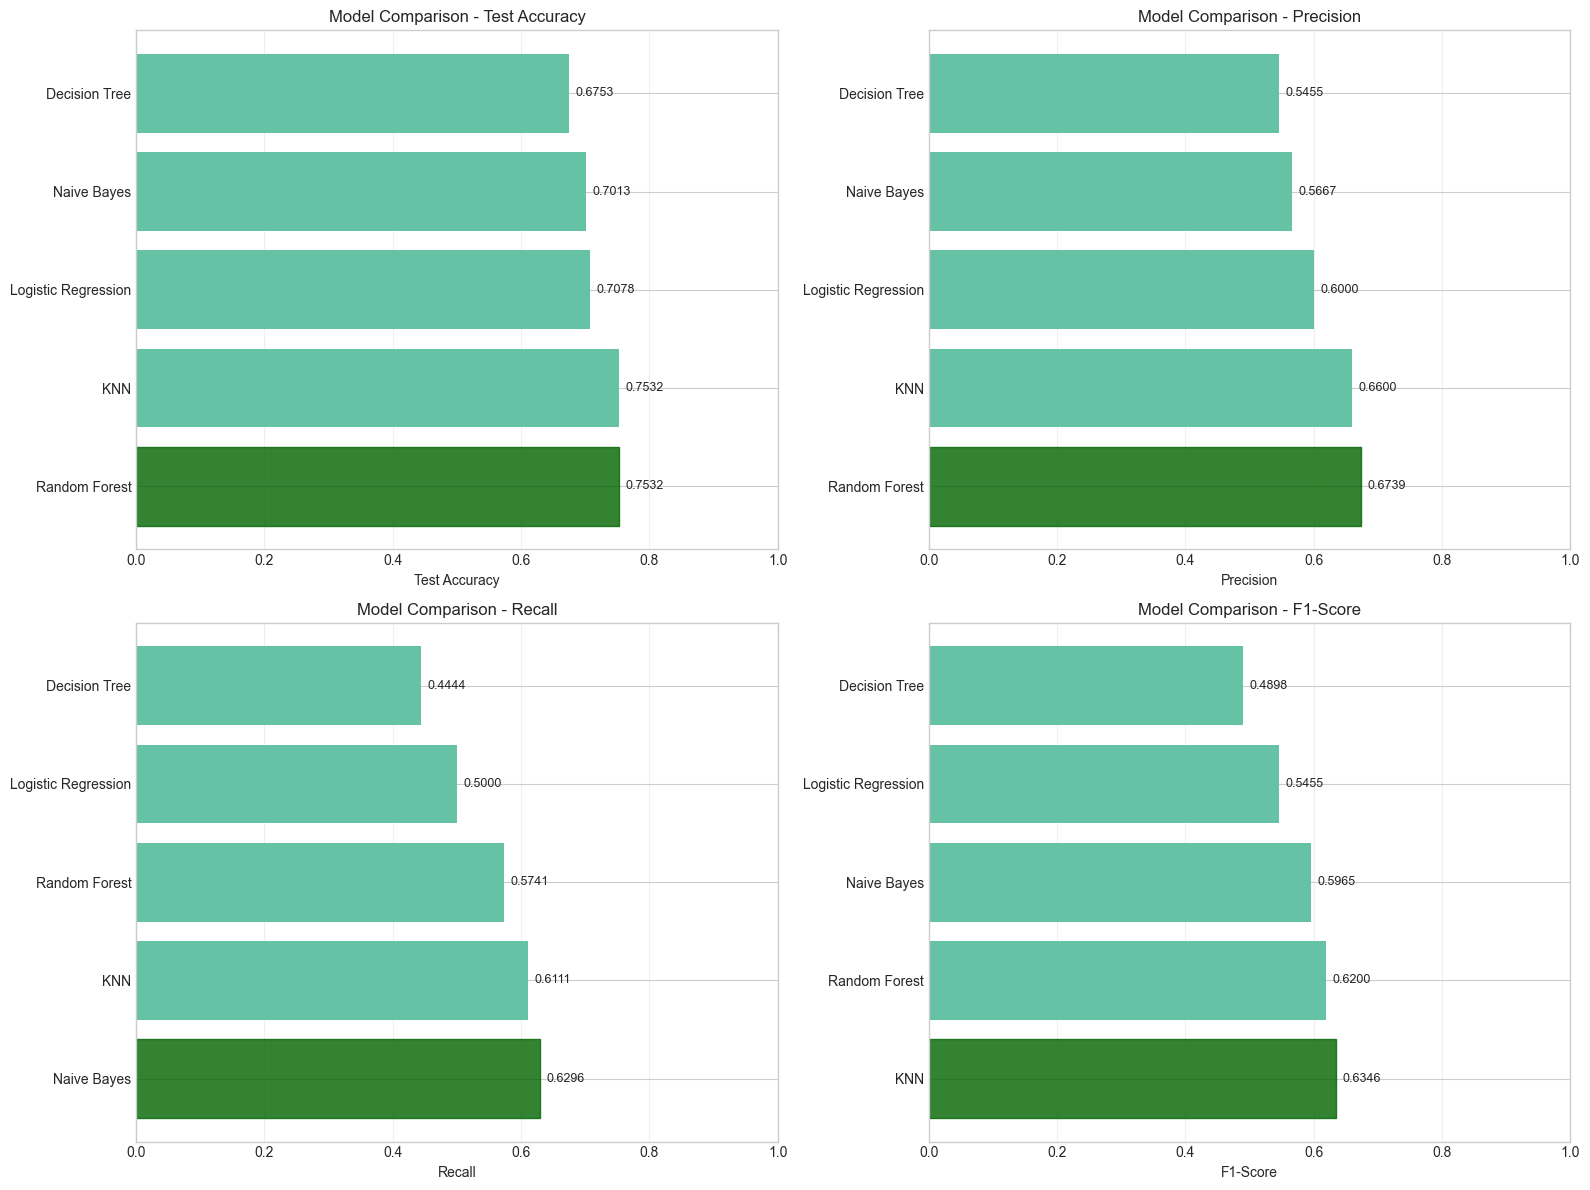

In [6]:
# Compare multiple metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['test_accuracy', 'precision', 'recall', 'f1_score']
titles = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Sort for this metric
    data_sorted = results_df.sort_values(metric, ascending=False)
    
    # Create bar plot
    bars = ax.barh(range(len(data_sorted)), data_sorted[metric])
    ax.set_yticks(range(len(data_sorted)))
    ax.set_yticklabels(data_sorted['model'])
    ax.set_xlabel(title)
    ax.set_title(f'Model Comparison - {title}')
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Color best model
    bars[0].set_color('darkgreen')
    bars[0].set_alpha(0.8)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, data_sorted[metric])):
        ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/10_model_comparison.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

## 6. ROC Curves Comparison

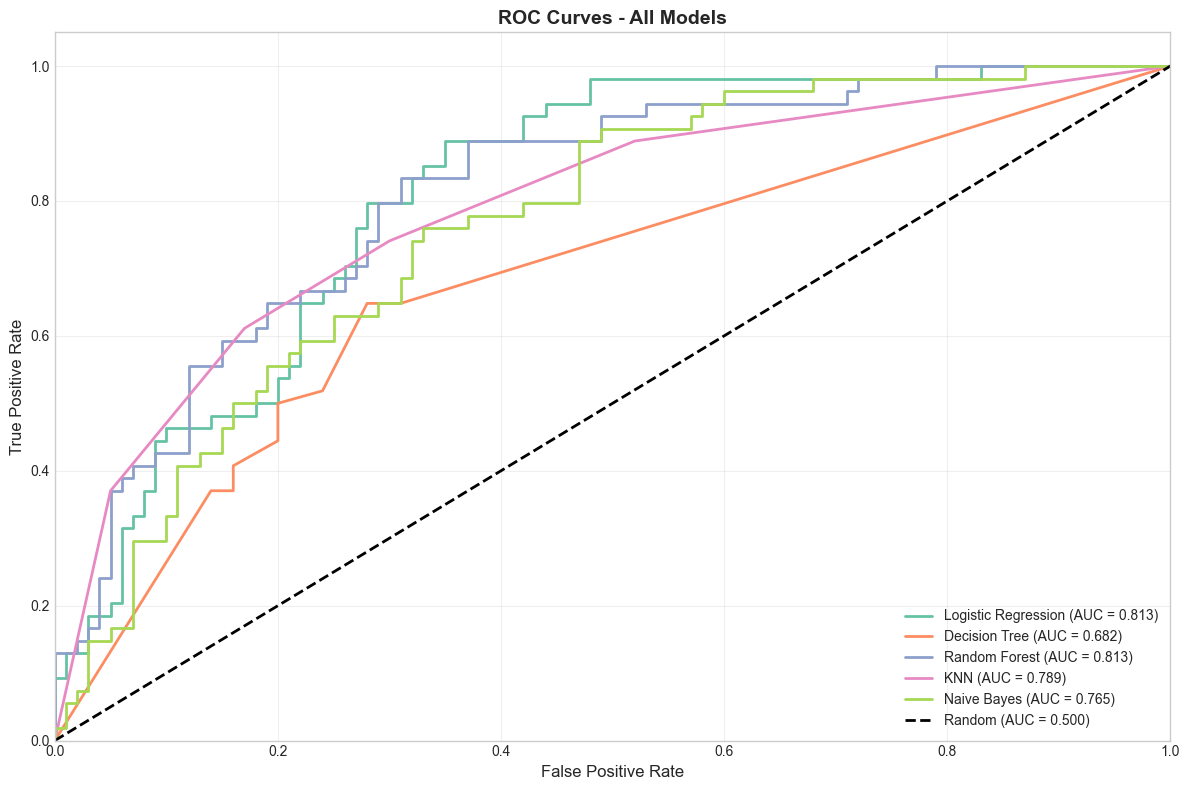

In [7]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for all models
plt.figure(figsize=(12, 8))

for model_name, model in trained_models.items():
    # Get probabilities
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/11_roc_curves_all.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

## 7. Confusion Matrices

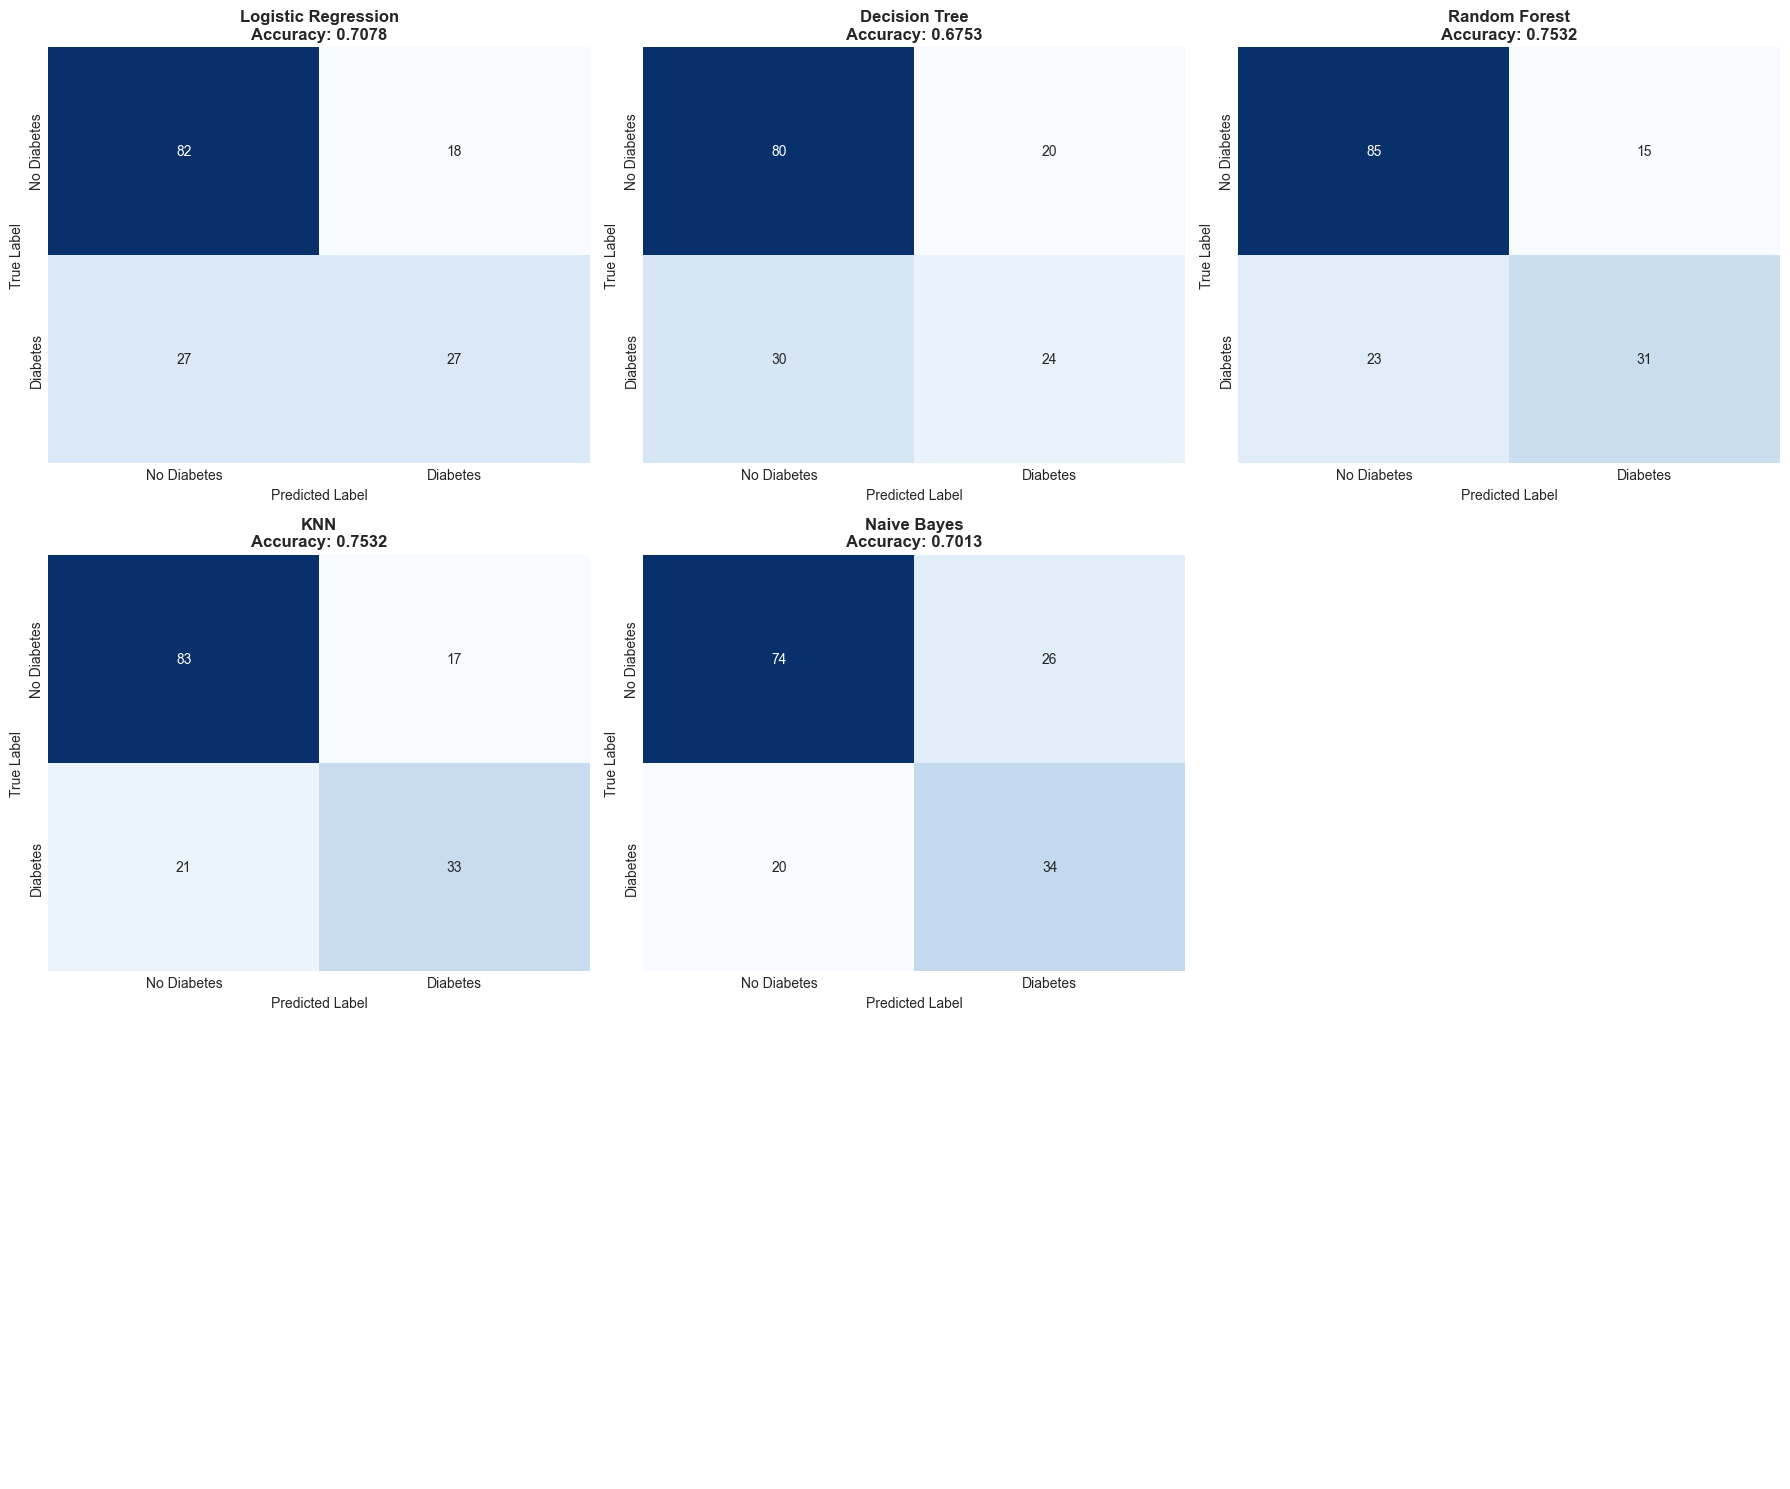

In [8]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, (model_name, metrics) in enumerate(results.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    cm = metrics['confusion_matrix']
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'],
                cbar=False)
    
    # Add title with accuracy
    acc = metrics['test_accuracy']
    ax.set_title(f'{model_name}\nAccuracy: {acc:.4f}', fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Hide unused subplots
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/12_confusion_matrices.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

## 8. Detailed Classification Reports

In [9]:
# Print detailed classification reports
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for model_name, model in trained_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{model_name}:")
    print("-" * 60)
    print(classification_report(y_test, y_pred, 
                               target_names=['No Diabetes', 'Diabetes'],
                               digits=4))


DETAILED CLASSIFICATION REPORTS

Logistic Regression:
------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes     0.7523    0.8200    0.7847       100
    Diabetes     0.6000    0.5000    0.5455        54

    accuracy                         0.7078       154
   macro avg     0.6761    0.6600    0.6651       154
weighted avg     0.6989    0.7078    0.7008       154


Decision Tree:
------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes     0.7273    0.8000    0.7619       100
    Diabetes     0.5455    0.4444    0.4898        54

    accuracy                         0.6753       154
   macro avg     0.6364    0.6222    0.6259       154
weighted avg     0.6635    0.6753    0.6665       154


Random Forest:
------------------------------------------------------------
              precision    recall  f1-score   support

 No Diabetes     0.78

## 9. Select and Save Best Model

In [10]:
# Determine best model based on multiple criteria
best_model_name = results_df.iloc[0]['model']
best_model = trained_models[best_model_name]
best_metrics = results[best_model_name]

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)
print(f"\nBest Model: {best_model_name}")
print("\nPerformance Metrics:")
print(f"  Test Accuracy:  {best_metrics['test_accuracy']:.4f}")
print(f"  Precision:      {best_metrics['precision']:.4f}")
print(f"  Recall:         {best_metrics['recall']:.4f}")
print(f"  F1-Score:       {best_metrics['f1_score']:.4f}")
print(f"  ROC-AUC:        {best_metrics['roc_auc']:.4f}")
print(f"  CV Mean (±std): {best_metrics['cv_mean']:.4f} (±{best_metrics['cv_std']:.4f})")
print("="*80)

# Save best model
utils.save_model(best_model, 'best_model.pkl')

# Also save scaler path reference
print(f"\n✓ Best model saved to: {config.MODELS_DIR}/best_model.pkl")
print(f"✓ Scaler available at: {config.MODELS_DIR}/scaler.pkl")


BEST MODEL SELECTION

Best Model: Random Forest

Performance Metrics:
  Test Accuracy:  0.7532
  Precision:      0.6739
  Recall:         0.5741
  F1-Score:       0.6200
  ROC-AUC:        0.8126
  CV Mean (±std): 0.7655 (±0.0287)
Model saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/best_model.pkl

✓ Best model saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/best_model.pkl
✓ Scaler available at: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/scaler.pkl


## 10. Feature Importance (for tree-based models)

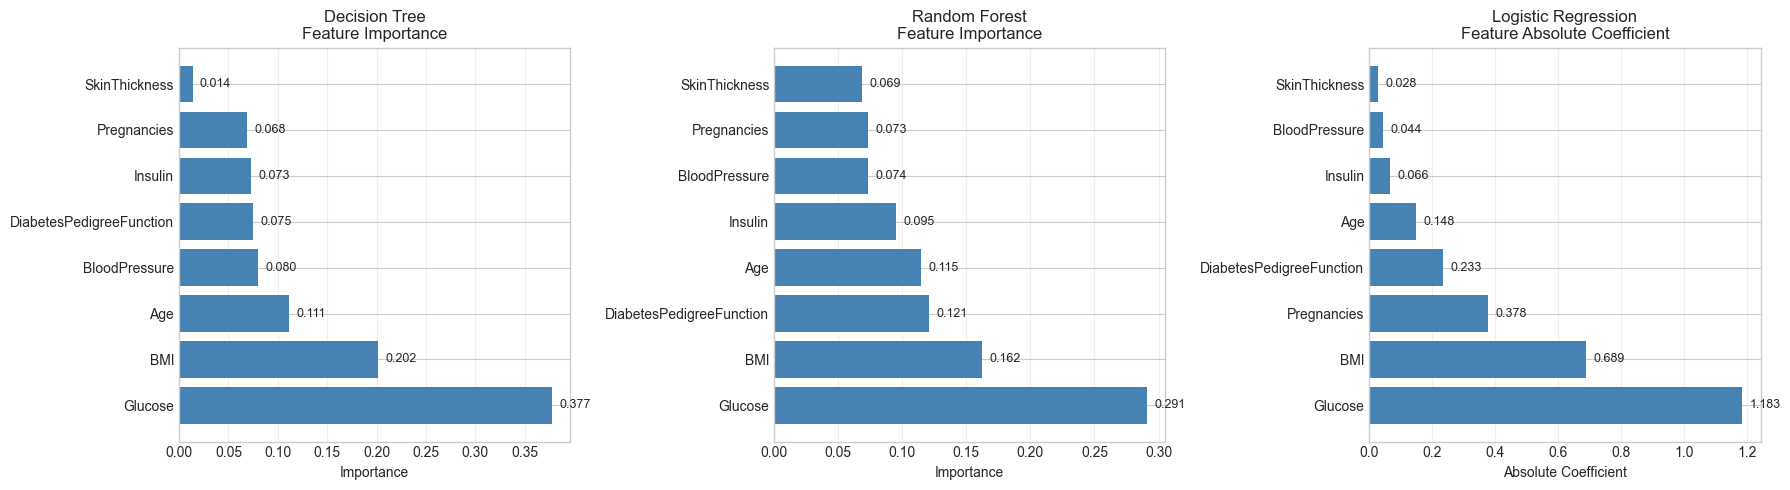


Feature Importance (Random Forest):
1. Glucose                       : 0.2909
2. BMI                           : 0.1624
3. DiabetesPedigreeFunction      : 0.1210
4. Age                           : 0.1148
5. Insulin                       : 0.0953
6. BloodPressure                 : 0.0736
7. Pregnancies                   : 0.0731
8. SkinThickness                 : 0.0690


In [11]:
# Get feature importance from multiple models
# Tree-based models: use feature_importances_
# Logistic Regression: use absolute values of coefficients

models_with_importance = ['Decision Tree', 'Random Forest', 'Logistic Regression']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(models_with_importance):
    if model_name in trained_models:
        model = trained_models[model_name]
        ax = axes[idx]
        
        # Get feature importances based on model type
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            importances = model.feature_importances_
            importance_type = 'Importance'
        elif hasattr(model, 'coef_'):
            # Linear models (Logistic Regression)
            importances = np.abs(model.coef_[0])
            importance_type = 'Absolute Coefficient'
        else:
            continue
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        # Plot
        ax.barh(range(len(importances)), importances[indices], color='steelblue')
        ax.set_yticks(range(len(importances)))
        ax.set_yticklabels([config.FEATURE_NAMES[i] for i in indices])
        ax.set_xlabel(importance_type)
        ax.set_title(f'{model_name}\nFeature {importance_type}')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, v in enumerate(importances[indices]):
            ax.text(v + max(importances) * 0.02, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/13_feature_importance.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

# Print feature importance for best model
if best_model_name in models_with_importance:
    model = best_model
    print(f"\nFeature Importance ({best_model_name}):")
    print("="*50)
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    
    indices = np.argsort(importances)[::-1]
    for i, idx in enumerate(indices, 1):
        print(f"{i}. {config.FEATURE_NAMES[idx]:30s}: {importances[idx]:.4f}")


## 11. Summary and Next Steps

In [12]:
print("\n" + "="*80)
print("MODEL TRAINING & EVALUATION SUMMARY")
print("="*80)

print(f"\n✓ Trained {len(models)} classification models")
print(f"✓ Evaluated using multiple metrics (accuracy, precision, recall, F1, ROC-AUC)")
print(f"✓ Performed {config.CV_FOLDS}-fold cross-validation")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Best test accuracy: {best_metrics['test_accuracy']:.4f}")

print("\nTop 3 Models by Test Accuracy:")
for idx, row in results_df.head(3).iterrows():
    print(f"  {idx+1}. {row['model']}: {row['test_accuracy']:.4f}")

print("\nNext Steps:")
print("  → Perform hyperparameter tuning on top models")
print("  → Analyze model performance on different patient subgroups")
print("  → Consider ensemble methods to improve predictions")

print("\n" + "="*80 + "\n")


MODEL TRAINING & EVALUATION SUMMARY

✓ Trained 5 classification models
✓ Evaluated using multiple metrics (accuracy, precision, recall, F1, ROC-AUC)
✓ Performed 5-fold cross-validation
✓ Best model: Random Forest
✓ Best test accuracy: 0.7532

Top 3 Models by Test Accuracy:
  1. Random Forest: 0.7532
  2. KNN: 0.7532
  3. Logistic Regression: 0.7078

Next Steps:
  → Perform hyperparameter tuning on top models
  → Analyze model performance on different patient subgroups
  → Consider ensemble methods to improve predictions


